In [1]:
import pandas as pd
import numpy as np

## Reading data

In [2]:
path="data/distinct_users_day.csv"
dud=pd.read_csv(path,sep=",",encoding="latin-1")
dud=dud[dud['CUST_CLASS']=='visitor'] #keep only visitors
dud=dud[['COD_PRO','VISITORS']].reset_index(drop=True) #keep relevant columns
dud

,COD_PRO,VISITORS
0,35.0,968
1,22.0,64
2,52.0,516
3,108.0,128
4,29.0,512
...,...,...
12307,65.0,36
12308,22.0,40
12309,16.0,36
12310,78.0,36


In [3]:
path="data/codici_istat_provincia.csv"
cod_prov=pd.read_csv(path,sep=",",encoding="latin-1")
cod_prov=cod_prov[['COD_PRO','PROVINCIA']].reset_index(drop=True) #same as before
cod_prov=cod_prov[cod_prov.COD_PRO!=-999]                         #removing others
cod_prov

,COD_PRO,PROVINCIA
0,1,Torino
1,2,Vercelli
2,3,Novara
3,4,Cuneo
4,5,Asti
...,...,...
102,90,Sassari
103,91,Nuoro
104,92,Cagliari
105,95,Oristano


```bash
cat data/Veneto.txt | tr ',' '.' > data/Veneto_fixed.txt
```

We used this bash command to replace commas to points in order to avoid conversion problems

In [4]:
#path='data/Veneto_fixed.txt'
url='https://www.dropbox.com/s/joockt9l4az3euk/Veneto_fixed.txt?dl=1'
distances=pd.read_csv(url,sep=";")
distances=distances[['Origine','Destinazione','Total_Mete']]
distances

,Origine,Destinazione,Total_Mete
0,1042.0,23059.0,243790.98
1,1042.0,23022.0,246794.26
2,1042.0,23082.0,253806.62
3,1042.0,23083.0,252084.96
4,1042.0,23043.0,251192.38
...,...,...,...
4241295,62067.0,25015.0,884264.20
4241296,62067.0,25014.0,875876.53
4241297,62067.0,25052.0,888212.30
4241298,62067.0,25044.0,883640.08


In [5]:
path="data/codici_istat_comune.csv"
cod_com=pd.read_csv(path,sep=",",encoding="latin-1")
cod_com

,COD_PRO,PRO_COM,COMUNE,COMUNE_CAPOLUOGO
0,1,1001,Agliè,0
1,1,1002,Airasca,0
2,1,1003,Ala di Stura,0
3,1,1004,Albiano d'Ivrea,0
4,1,1005,Alice Superiore,0
...,...,...,...,...
7950,111,111104,Villasalto,0
7951,111,111105,Villasimius,0
7952,111,111106,Villasor,0
7953,111,111107,Villaspeciosa,0


In [6]:
dic={}
for index, row in cod_com.iterrows():
    dic[row.PRO_COM]=row.COD_PRO

def com_to_prov(c):
    try:
        p=dic[c]
    except:
        p=com_to_prov(c+1)
    return p
com_to_prov=np.vectorize(com_to_prov)

In [7]:
origine=distances.Origine.astype(int).values
destinazione=distances.Destinazione.astype(int).values



print(origine[:2])
origine=com_to_prov(origine)
print(origine[:2])

destinazione=com_to_prov(destinazione)
#Now in origine I have the province instead of the comune

[1042 1042]
[1 1]


In [8]:
cod_Padova=cod_prov[cod_prov.PROVINCIA=='Padova'].COD_PRO.values[0]
distances['Origine']=origine
distances['Destinazione']=destinazione

distances=distances[distances.Destinazione==cod_Padova]
distances=distances.groupby(['Origine','Destinazione'],as_index=False).mean()

distances

,Origine,Destinazione,Total_Mete
0,1,28,3.943948e+05
1,2,28,3.382826e+05
2,3,28,3.067730e+05
3,4,28,4.339346e+05
4,5,28,3.676197e+05
...,...,...,...
88,102,28,1.093870e+06
89,103,28,3.541547e+05
90,108,28,2.417719e+05
91,109,28,3.961239e+05


In [9]:
dud=dud.groupby(['COD_PRO'],as_index=False).sum()

In [10]:
dic={}
for index, row in distances.iterrows():
    dic[row.Origine]=row.Total_Mete

def prov_to_dist(p):
    try: 
        d=dic[p]
    except:
        d=-1
    return d 
prov_to_dist=np.vectorize(prov_to_dist)

In [11]:
dud['DISTANCES']=prov_to_dist(dud.COD_PRO.astype(int))
print(np.sum(dud.VISITORS[dud.DISTANCES==-1]))
dud=dud[dud.DISTANCES!=-1]
dud

35980


,COD_PRO,VISITORS,DISTANCES
0,1.0,39068,3.943948e+05
1,2.0,1940,3.382826e+05
2,3.0,9164,3.067730e+05
3,4.0,3372,4.339346e+05
4,5.0,1440,3.676197e+05
...,...,...,...
100,102.0,428,1.093870e+06
101,103.0,2000,3.541547e+05
105,108.0,30648,2.417719e+05
106,109.0,2676,3.961239e+05


In [12]:
dist=dud.DISTANCES.values
freq=dud.VISITORS.values
nbins=120
bins=np.linspace(np.min(dist),np.max(dist),nbins+1)

f_bins=[]
for i in range(len(bins)-1):
    f=np.sum(freq[dist<=bins[i+1]])
    f-=np.sum(freq[dist<bins[i]])
    f_bins.append(f)

bins=(bins[1:]+bins[:-1])*0.5

In [13]:
sum(f_bins) == np.sum(freq)

True

In [14]:
cod_Milano=cod_prov[cod_prov.PROVINCIA=='Milano'].COD_PRO.values[0]
cod_Venezia=cod_prov[cod_prov.PROVINCIA=='Venezia'].COD_PRO.values[0]
cod_Roma=cod_prov[cod_prov.PROVINCIA=='Roma'].COD_PRO.values[0]

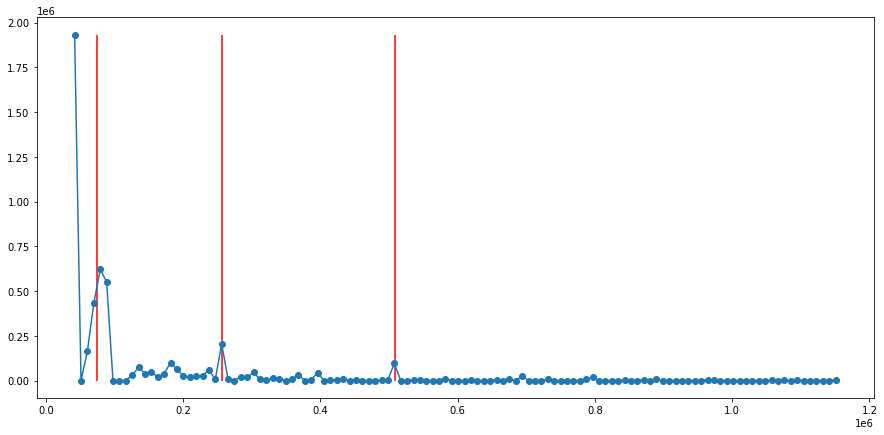

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(bins,f_bins,'-o')

plt.vlines(prov_to_dist(cod_Milano),min(f_bins),max(f_bins),color='r')
plt.vlines(prov_to_dist(cod_Venezia),min(f_bins),max(f_bins),color='r')
plt.vlines(prov_to_dist(cod_Roma),min(f_bins),max(f_bins),color='r')
